<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial104_DL_terminology_callbacks_checkpoints_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/vXL64p-Nk6U

**Understanding deep learning terminology**

This code can be used to explain callbacks, checkpoints and early stopping


**cifar10 dataset**

60,000 32×32 pixel images divided into 10 classes.

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plt.style.use('classic')

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.datasets import cifar10
from keras.utils import normalize, to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop



In [ ]:
#Let us extract only the 50000 training data available from cifar for this exercise.  
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


print("The size of training dataset is: ", X_train.shape)
print("The size of testing dataset is: ", X_test.shape)
print("The size of training dataset y is: ", y_train.shape)
print("The size of testing dataset y is: ", y_test.shape)

The size of training dataset is:  (50000, 32, 32, 3)
The size of testing dataset is:  (10000, 32, 32, 3)
The size of training dataset y is:  (50000, 1)
The size of testing dataset y is:  (10000, 1)


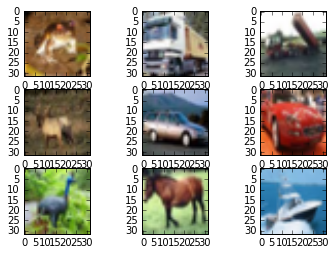

In [ ]:
#view few images 
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i])
plt.show()

In [ ]:
X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.


In [ ]:
# Print a few y_train values to see before and after categorical
print(y_train[0])
print(y_train[1])
print(y_train[10])

[6]
[9]
[4]


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(y_train[0])
print(y_train[1])
print(y_train[10])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# Create a model with dropout
drop=0.0  #Setting to 0.5 so the training stops when it encounters overfitting. 

#Kernel = zeros --> No change in weights... like vanishing gradient problem
#kernel = random --> Performs better but when you rerun the experiment the results may vary quite a bit, depends on the application. 
#kernel = he_uniform --> Ideal to work with relu. 
#kernel = glorot_uniform --> similar to he_uniform but different variance. he_uniform is preferred with ReLu

kernel_initializer =  'he_uniform'  #Also try 'zeros', 'random_uniform', 'he_uniform', 'glorot_uniform'

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', input_shape=(32, 32, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(drop))

model1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Dropout(drop))

model1.add(Flatten())
model1.add(Dense(512, activation='relu', kernel_initializer=kernel_initializer))
model1.add(Dropout(drop))
model1.add(Dense(10, activation='softmax'))

opt1 = SGD(lr=0.001, momentum=0.9)
opt2 = RMSprop(lr=0.001, decay=1e-6)
model1.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [ ]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 

#Give unique name to save all models as accuracy improves
filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.

#Overwrite the model each time accuracy improves. Saves a lot of space. 
#filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
#########################################################
#Fit model....

history1 = model1.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks_list)



Epoch 1/25
782/782 [==============================] - 9s 8ms/step - loss: 1.8857 - accuracy: 0.3183 - val_loss: 1.4500 - val_accuracy: 0.4846

Epoch 00001: val_accuracy improved from -inf to 0.48460, saving model to /content/drive/MyDrive/Colab Notebooks/saved_models/weights-improvement-01-0.48.hdf5
Epoch 2/25
782/782 [==============================] - 6s 8ms/step - loss: 1.4167 - accuracy: 0.4956 - val_loss: 1.2648 - val_accuracy: 0.5490

Epoch 00002: val_accuracy improved from 0.48460 to 0.54900, saving model to /content/drive/MyDrive/Colab Notebooks/saved_models/weights-improvement-02-0.55.hdf5
Epoch 3/25
782/782 [==============================] - 6s 8ms/step - loss: 1.2378 - accuracy: 0.5609 - val_loss: 1.1443 - val_accuracy: 0.5972

Epoch 00003: val_accuracy improved from 0.54900 to 0.59720, saving model to /content/drive/MyDrive/Colab Notebooks/saved_models/weights-improvement-03-0.60.hdf5
Epoch 4/25
782/782 [==============================] - 6s 8ms/step - loss: 1.1092 - accuracy

In [ ]:
_, acc = model1.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

313/313 [==============================] - 1s 3ms/step - loss: 0.9451 - accuracy: 0.7040
Accuracy =  70.39999961853027 %


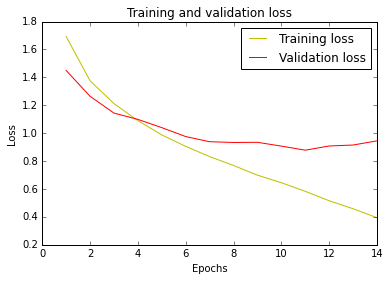

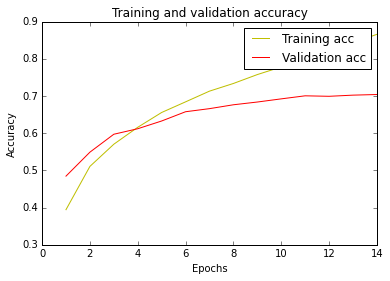

In [ ]:
#####################################################################
#plot the training and validation accuracy and loss at each epoch
#If validation loss is lower than training loss this could be becuase we are applying
#regularization (Dropout) during training which won't be applied during validation. 
#Also, training loss is measured during each epoch while validation is done after the epoch. 

history = history1

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




